In [353]:
import pandas as pd
import numpy as np
from numpy import int64
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## inequity analysis

In [354]:
def calculate_vif(df, features):
    X = df[features]
    X['Intercept'] = 1
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.dropna()

def ejscreen_year_analysis(year):
    ejscreen = pd.read_csv('Allocation to Census tracts_v3/population_results/heatmaps/ejscreen_impacted_{}_full.csv'.format(year))
    for i in range(1, 10):
        ejscreen[f'pfas_only_{i+1}'] = ejscreen[f'pfas_within_{i+1}'] - ejscreen[f'pfas_within_{i}']
    ejscreen['pfas_only_1'] = ejscreen['pfas_within_1']
    ejscreen['weighted_exposure'] = sum((1/(i+1)) * ejscreen[f'pfas_only_{i+1}'] for i in range(10))
    ejscreen['weighted_exposure_log'] = np.log(ejscreen['weighted_exposure'] + 1)
    return ejscreen

def ols_df_process(year):
    acs = pd.read_csv('pnas_acs/acs_filtered.csv')
    acs['median_hh_income'] = pd.to_numeric(acs['median_hh_income'], errors='coerce')
    acs['income_log'] = np.log(acs['median_hh_income']+1)
    acs['income_log_pct'] = acs['income_log'].rank(pct=True)
    acs.dropna(subset=['income_log'], inplace=True)
    ejscreen_og = pd.read_csv('EJSCREEN/EJSCREEN_2023_Tracts_with_AS_CNMI_GU_VI_csv/EJSCREEN_2023_Tracts_with_AS_CNMI_GU_VI.csv')
    ejscreen_og = ejscreen_og.merge(acs, left_on='ID', right_on='GEOID', how='inner')
    ejscreen = ejscreen_year_analysis(year)
    feats = [
        'P_RSEI_AIR',
        'P_PM25',
        'P_LDPNT',
        'P_PRMP', # RMP Facility Proximity
        'P_PWDIS',
        'P_DSLPM',
        'P_RESP',
        'P_PTRAF',
        'P_PNPL', # Superfund proximity
        'P_PTSDF', # Hazardous waste proximity 
        'P_UST', # Underground storage tanks
        'P_PEOPCOLORPCT', 'P_LOWINCPCT'
        , 'P_UNEMPPCT', 'P_LESSHSPCT'
        # 'PEOPCOLORPCT', 'LOWINCPCT'
        ]
    demo_feats = ['white_p', 'black_p', 'asian_p', 'hispanic_p', 'median_hh_income', 'income_log_pct']
    ols_df = ejscreen_og[['OID_', 'ID'] + feats + demo_feats].merge(ejscreen[['OID_', 'CNTY_NAME', 'weighted_exposure'] + ['pfas_within_' + str(i+1) for i in range(10)]], on='OID_', how='left')
    for col in ['pfas_within_' + str(i+1) for i in range(10)] + ['weighted_exposure']:
        ols_df[col] = ols_df[col].fillna(0)
    ols_df['weighted_exposure_log'] = np.log(ols_df['weighted_exposure'] + 1)
    ols_df.dropna(inplace=True)
    ols_df.reset_index(drop=True, inplace=True)
    for col in feats:
        ols_df[col] = ols_df[col]/100
    return ols_df


def ols_df_process_emission(year):
    acs = pd.read_csv('pnas_acs/acs_filtered.csv')
    acs['median_hh_income'] = pd.to_numeric(acs['median_hh_income'], errors='coerce')
    acs['income_log'] = np.log(acs['median_hh_income']+1)
    acs['income_log_pct'] = acs['income_log'].rank(pct=True)
    acs.dropna(subset=['income_log'], inplace=True)
    ejscreen_og = pd.read_csv('EJSCREEN/EJSCREEN_2023_Tracts_with_AS_CNMI_GU_VI_csv/EJSCREEN_2023_Tracts_with_AS_CNMI_GU_VI.csv')
    ejscreen_og = ejscreen_og.merge(acs, left_on='ID', right_on='GEOID', how='inner')
    emission = pd.read_csv('Allocation to Census tracts_v3/13_CTInUseEmission_PC_High_StatusQuo/CTInUseEmission_PC_High_StatusQuo_{}.csv'.format(year)) # old results in the first iteration

    emission['GEOID'] = emission['GEO_ID'].str[9:]
    emission['GEOID'] = emission['GEOID'].astype(int64)
    emission[f'{year}'] = emission[f'{year}'].fillna(0)
    emission['pc_emission'] = emission[f'{year}']
    emission['pc_emission_log'] = np.log(emission['pc_emission'] + 1)
    feats = [
        'P_RSEI_AIR',
        'P_PM25',
        'P_LDPNT',
        'P_PRMP', # RMP Facility Proximity
        'P_PWDIS',
        'P_DSLPM',
        'P_RESP',
        'P_PTRAF',
        'P_PNPL', # Superfund proximity
        'P_PTSDF', # Hazardous waste proximity 
        'P_UST', # Underground storage tanks
        'P_PEOPCOLORPCT', 'P_LOWINCPCT'
        , 'P_UNEMPPCT', 'P_LESSHSPCT'
        # 'PEOPCOLORPCT', 'LOWINCPCT'    
        ]
    demo_feats = ['white_p', 'black_p', 'asian_p', 'hispanic_p', 'median_hh_income', 'income_log_pct']
    ols_df = ejscreen_og[['ID', 'CNTY_NAME'] + feats + demo_feats].merge(emission[['GEOID', 'pc_emission']], left_on='ID', right_on='GEOID', how='left') #, f'{year}'
    ols_df.dropna(inplace=True)
    ols_df.reset_index(drop=True, inplace=True)
    for col in feats:
        ols_df[col] = ols_df[col]/100
    return ols_df

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

coeffs = {}
lower_confs = {}
upper_confs = {}
pvals = {}

for year in [2020, 2030, 2040, 2050, 2060]:
    df = ols_df_process(year)
    model = smf.mixedlm("weighted_exposure_log ~ P_PRMP + P_PM25 + P_PNPL + P_PEOPCOLORPCT + P_UNEMPPCT", data=df, groups=df["CNTY_NAME"], re_formula="~1")
    model = model.fit()
    print(year)
    print(model.summary())

    for i, feature in enumerate(['coeffs', 'P_PRMP', 'P_PM25', 'P_PNPL', 'P_PEOPCOLORPCT', 'P_UNEMPPCT']):
        if feature not in coeffs:
            coeffs[feature] = []
            lower_confs[feature] = []
            upper_confs[feature] = []
            pvals[feature] = []
        coeffs[feature].append(model.params[i])
        lower_confs[feature].append(model.conf_int().iloc[i, 0])
        upper_confs[feature].append(model.conf_int().iloc[i, 1])
        pvals[feature].append(model.pvalues[i])

# create a DataFrame from the dictionary
coeffs_df = pd.DataFrame(coeffs)
lower_confs_df = pd.DataFrame(lower_confs)
upper_confs_df = pd.DataFrame(upper_confs)
pvals_df = pd.DataFrame(pvals)
coeffs_df['year'] = [2020, 2030, 2040, 2050, 2060]
lower_confs_df['year'] = [2020, 2030, 2040, 2050, 2060]
upper_confs_df['year'] = [2020, 2030, 2040, 2050, 2060]
pvals_df['year'] = [2020, 2030, 2040, 2050, 2060]
lower_confs_df.rename(columns={'coeffs': 'coeffs_lower', 'P_RSEI_AIR': 'P_RSEI_AIR_lower', 'P_PM25': 'P_PM25_lower', 'P_LDPNT': 'P_LDPNT_lower', 'P_PRMP': 'P_PRMP_lower', 'P_PWDIS': 'P_PWDIS_lower', 'P_PEOPCOLORPCT': 'P_PEOPCOLORPCT_lower', 'P_LOWINCPCT': 'P_LOWINCPCT_lower', 'P_PNPL': 'P_PNPL_lower', 'income_log_pct': 'income_log_pct_lower', 'P_UNEMPPCT': 'P_UNEMPPCT_lower', 'P_LESSHSPCT': 'P_LESSHSPCT_lower', 'P_PTSDF': 'P_PTSDF_lower', 'P_UST': 'P_UST_lower'}, inplace=True)
upper_confs_df.rename(columns={'coeffs': 'coeffs_upper', 'P_RSEI_AIR': 'P_RSEI_AIR_upper', 'P_PM25': 'P_PM25_upper', 'P_LDPNT': 'P_LDPNT_upper', 'P_PRMP': 'P_PRMP_upper', 'P_PWDIS': 'P_PWDIS_upper', 'P_PEOPCOLORPCT': 'P_PEOPCOLORPCT_upper', 'P_LOWINCPCT': 'P_LOWINCPCT_upper', 'P_PNPL': 'P_PNPL_upper', 'income_log_pct': 'income_log_pct_upper', 'P_UNEMPPCT': 'P_UNEMPPCT_upper', 'P_LESSHSPCT': 'P_LESSHSPCT_upper', 'P_PTSDF': 'P_PTSDF_upper', 'P_UST': 'P_UST_upper'}, inplace=True)
pvals_df.rename(columns={'coeffs': 'coeffs_pval', 'P_RSEI_AIR': 'P_RSEI_AIR_pval', 'P_PM25': 'P_PM25_pval', 'P_LDPNT': 'P_LDPNT_pval', 'P_PRMP': 'P_PRMP_pval', 'P_PWDIS': 'P_PWDIS_pval', 'P_PEOPCOLORPCT': 'P_PEOPCOLORPCT_pval', 'P_LOWINCPCT': 'P_LOWINCPCT_pval', 'P_PNPL': 'P_PNPL_pval', 'income_log_pct': 'income_log_pct_pval', 'P_UNEMPPCT': 'P_UNEMPPCT_pval', 'P_LESSHSPCT': 'P_LESSHSPCT_pval', 'P_PTSDF': 'P_PTSDF_pval', 'P_UST': 'P_UST_pval'}, inplace=True)
coeffs_df = coeffs_df.merge(lower_confs_df, on='year').merge(upper_confs_df, on='year')
coeffs_df = coeffs_df.merge(pvals_df, on='year')

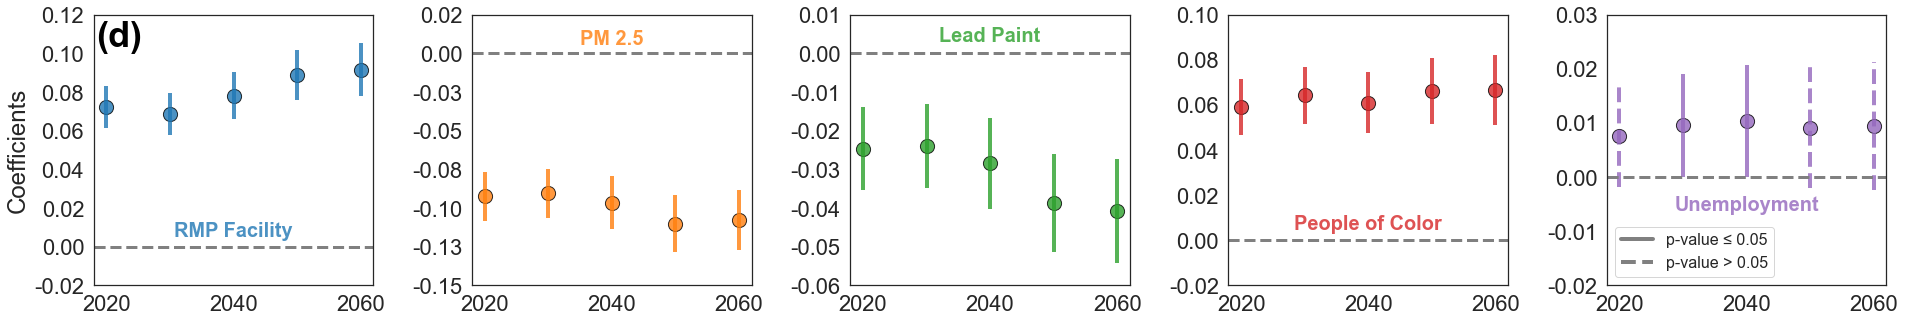

In [204]:
import matplotlib.lines as mlines

labels_dict = {'P_PRMP': 'RMP Facility', 
                'P_PM25': 'PM 2.5', 
                'P_LDPNT': 'Lead Paint', 
                'P_PEOPCOLORPCT': 'People of Color', 
                'P_LOWINCPCT':'Low Income',
                'income_log_pct': 'Income',
                'P_UNEMPPCT': 'Unemployment',
                'P_LESSHSPCT':'ed'}

colors = sns.color_palette("tab10", 5)

pval_threshold = 0.059

sns.set(style='white', font_scale=2)
fig, ax = plt.subplots(1, 5, figsize=(27, 5))
plt.subplots_adjust(wspace=0.25) 

for i, feature in enumerate(['P_PRMP', 'P_PM25', 'P_LDPNT', 'P_PEOPCOLORPCT', 'P_UNEMPPCT']):
    for j, year in enumerate(coeffs_df['year']):
        pval = coeffs_df['{}_pval'.format(feature)].iloc[j]
        
        # Choose line style based on p-value significance
        if pval < pval_threshold:
            linestyle = '-'
        else:
            linestyle = '--'  # Dashed line for non-significant p-values
            
        # Plot vlines with the chosen linestyle
        ax[i].vlines(year, coeffs_df['{}_lower'.format(feature)].iloc[j], coeffs_df['{}_upper'.format(feature)].iloc[j], 
                     alpha=0.8, lw=4, color=colors[i], linestyle=linestyle)
    
    # Plot scatter points
    ax[i].scatter(coeffs_df['year'], coeffs_df[feature], marker='o', label=feature, edgecolors='black', 
                  s=200, alpha=0.8, color=colors[i])
    ax[i].axhline(0, color='grey', lw=3, linestyle='--')

    # Set text and labels (same as before)
    if feature == 'P_LDPNT':
        ax[i].text(2040,0.002, labels_dict[feature], ha='center', va='bottom', fontsize=20, fontweight='bold', alpha=0.8, color=colors[i])
    elif feature == 'P_UNEMPPCT':
        ax[i].text(2040,-0.007, labels_dict[feature], ha='center', va='bottom', fontsize=20, fontweight='bold', alpha=0.8, color=colors[i])
        ax[i].set_ylim(-0.02, 0.025)  # Set y-axis limit for P_UNEMPPCT
    else:
        ax[i].text(2040,0.003, labels_dict[feature], ha='center', va='bottom', fontsize=20, fontweight='bold', alpha=0.8, color=colors[i])
    
    yticks = ax[i].get_yticks()
    ax[i].set_yticks(yticks)  # Set the existing y-tick locations
    ax[i].set_yticklabels([f'{ytick:.2f}' for ytick in yticks])  # Format y-tick labels

    ax[i].set_ylabel('')
    if i ==0:
        ax[i].text(2022,0.1, '(d)', ha='center', va='bottom', fontsize=36, fontweight='bold', color='black')
        ax[i].set_ylabel('Coefficients')

solid_line = mlines.Line2D([], [], color='grey', linestyle='-', label='p-value ≤ 0.05', lw=4)
dashed_line = mlines.Line2D([], [], color='grey', linestyle='--', label='p-value > 0.05', lw=4)
ax[-1].legend(handles=[solid_line, dashed_line], loc='lower left', fontsize=16)

plt.tight_layout()

In [236]:
exposure_df = ols_df_process(2020)[['ID', 'CNTY_NAME', 'weighted_exposure']]
exposure_df.rename(columns={'weighted_exposure': 'weighted_exposure_{}'.format(2020)}, inplace=True)
for year in [2030, 2040, 2050, 2060]:
    df = ols_df_process(year)
    df_ = df[['ID', 'weighted_exposure']]
    df_.rename(columns={'weighted_exposure': 'weighted_exposure_{}'.format(year)}, inplace=True)
    exposure_df = exposure_df.merge(df_, on='ID', how='inner')

In [67]:
# find the IDS that have zero exposure in all years
ids_exp = exposure_df[(exposure_df['weighted_exposure_2020'] == 0) & (exposure_df['weighted_exposure_2030'] == 0) & (exposure_df['weighted_exposure_2040'] == 0) & (exposure_df['weighted_exposure_2050'] == 0) & (exposure_df['weighted_exposure_2060'] == 0)]['ID'].tolist()
ids_exp_ = exposure_df[~exposure_df['ID'].isin(ids_exp)]

In [68]:
describe_y1 = ids_exp_.describe()
describe_y1.drop(columns=['ID'], inplace=True)

### Figure 4.b

In [3]:
def gini_index(exposure):
    n = len(exposure)
    exposure_sorted = np.sort(exposure)
    cumulative_exposure = np.cumsum(exposure_sorted)
    cumulative_exposure = np.insert(cumulative_exposure, 0, 0)  # Insert 0 at the beginning
    cumulative_proportion_exposure = cumulative_exposure / cumulative_exposure[-1]
    cumulative_proportion_population = np.arange(0, n+1) / n
    lorenz_area = np.trapz(cumulative_proportion_exposure, cumulative_proportion_population)
    gini = 1 - 2 * lorenz_area
    return gini, cumulative_proportion_population, cumulative_proportion_exposure

def plot_lorenz_curves(data, columns, styles):
    sns.set(style='white', font_scale=1.5)
    plt.figure(figsize=(9, 7))
    for column, style in zip(columns, styles):
        gini, cum_pop, cum_exp = gini_index(data[column])
        plt.plot(cum_pop, cum_exp, style, label=f'{column[-4:]} (Gini = {gini:.2f})', lw=2.5)
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Line of Equality', lw=2)
    
    plt.hlines(0.3, 0, 1, color='black', linestyle='--', lw=3)
    plt.vlines(0.78, 0, 1, color='black', linestyle='--', lw=3)
    
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    
    plt.xlabel('Cumulative Proportion of Census Tracts')
    plt.ylabel('Cumulative Proportion of Weighted Exposure')
    
    plt.legend()
    plt.text(0.9,0.1, '(b)', ha='center', va='bottom', fontsize=32, fontweight='bold', color='black')
    plt.tight_layout()

columns = ['weighted_exposure_2020', 'weighted_exposure_2030', 'weighted_exposure_2040', 'weighted_exposure_2050', 'weighted_exposure_2060']
styles = ['b-', 'g--', 'r-.', 'c:', 'm--']
plot_lorenz_curves(ids_exp_, columns, styles)

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

coeffs = {}
lower_confs = {}
upper_confs = {}
pvals = {}

for year in [2020, 2030, 2040, 2050, 2060]:
    df = ols_df_process_emission(year)
    model = smf.mixedlm("pc_emission ~ P_PRMP + P_PM25 + P_PNPL + P_PEOPCOLORPCT + P_UNEMPPCT", data=df, groups=df["CNTY_NAME"], re_formula="~1")
    model = model.fit()
    print(year)
    print(model.summary())

    for i, feature in enumerate(['coeffs', 'P_PRMP', 'P_PM25', 'P_PNPL', 'P_PEOPCOLORPCT', 'P_UNEMPPCT']):
        if feature not in coeffs:
            coeffs[feature] = []
            lower_confs[feature] = []
            upper_confs[feature] = []
            pvals[feature] = []
        coeffs[feature].append(model.params[i])
        lower_confs[feature].append(model.conf_int().iloc[i, 0])
        upper_confs[feature].append(model.conf_int().iloc[i, 1])
        pvals[feature].append(model.pvalues[i])

coeffs_df = pd.DataFrame(coeffs)
lower_confs_df = pd.DataFrame(lower_confs)
upper_confs_df = pd.DataFrame(upper_confs)
pvals_df = pd.DataFrame(pvals)
coeffs_df['year'] = [2020, 2030, 2040, 2050, 2060]
lower_confs_df['year'] = [2020, 2030, 2040, 2050, 2060]
upper_confs_df['year'] = [2020, 2030, 2040, 2050, 2060]
pvals_df['year'] = [2020, 2030, 2040, 2050, 2060]
lower_confs_df.rename(columns={'coeffs': 'coeffs_lower', 'P_RSEI_AIR': 'P_RSEI_AIR_lower', 'P_PM25': 'P_PM25_lower', 'P_LDPNT': 'P_LDPNT_lower', 'P_PRMP': 'P_PRMP_lower', 'P_PWDIS': 'P_PWDIS_lower', 'P_PEOPCOLORPCT': 'P_PEOPCOLORPCT_lower', 'P_LOWINCPCT': 'P_LOWINCPCT_lower', 'P_PNPL': 'P_PNPL_lower', 'income_log_pct': 'income_log_pct_lower', 'P_UNEMPPCT': 'P_UNEMPPCT_lower', 'P_LESSHSPCT': 'P_LESSHSPCT_lower', 'P_PTSDF': 'P_PTSDF_lower', 'P_UST': 'P_UST_lower'}, inplace=True)
upper_confs_df.rename(columns={'coeffs': 'coeffs_upper', 'P_RSEI_AIR': 'P_RSEI_AIR_upper', 'P_PM25': 'P_PM25_upper', 'P_LDPNT': 'P_LDPNT_upper', 'P_PRMP': 'P_PRMP_upper', 'P_PWDIS': 'P_PWDIS_upper', 'P_PEOPCOLORPCT': 'P_PEOPCOLORPCT_upper', 'P_LOWINCPCT': 'P_LOWINCPCT_upper', 'P_PNPL': 'P_PNPL_upper', 'income_log_pct': 'income_log_pct_upper', 'P_UNEMPPCT': 'P_UNEMPPCT_upper', 'P_LESSHSPCT': 'P_LESSHSPCT_upper', 'P_PTSDF': 'P_PTSDF_upper', 'P_UST': 'P_UST_upper'}, inplace=True)
pvals_df.rename(columns={'coeffs': 'coeffs_pval', 'P_RSEI_AIR': 'P_RSEI_AIR_pval', 'P_PM25': 'P_PM25_pval', 'P_LDPNT': 'P_LDPNT_pval', 'P_PRMP': 'P_PRMP_pval', 'P_PWDIS': 'P_PWDIS_pval', 'P_PEOPCOLORPCT': 'P_PEOPCOLORPCT_pval', 'P_LOWINCPCT': 'P_LOWINCPCT_pval', 'P_PNPL': 'P_PNPL_pval', 'income_log_pct': 'income_log_pct_pval', 'P_UNEMPPCT': 'P_UNEMPPCT_pval', 'P_LESSHSPCT': 'P_LESSHSPCT_pval', 'P_PTSDF': 'P_PTSDF_pval', 'P_UST': 'P_UST_pval'}, inplace=True)
coeffs_df = coeffs_df.merge(lower_confs_df, on='year').merge(upper_confs_df, on='year')
coeffs_df = coeffs_df.merge(pvals_df, on='year')

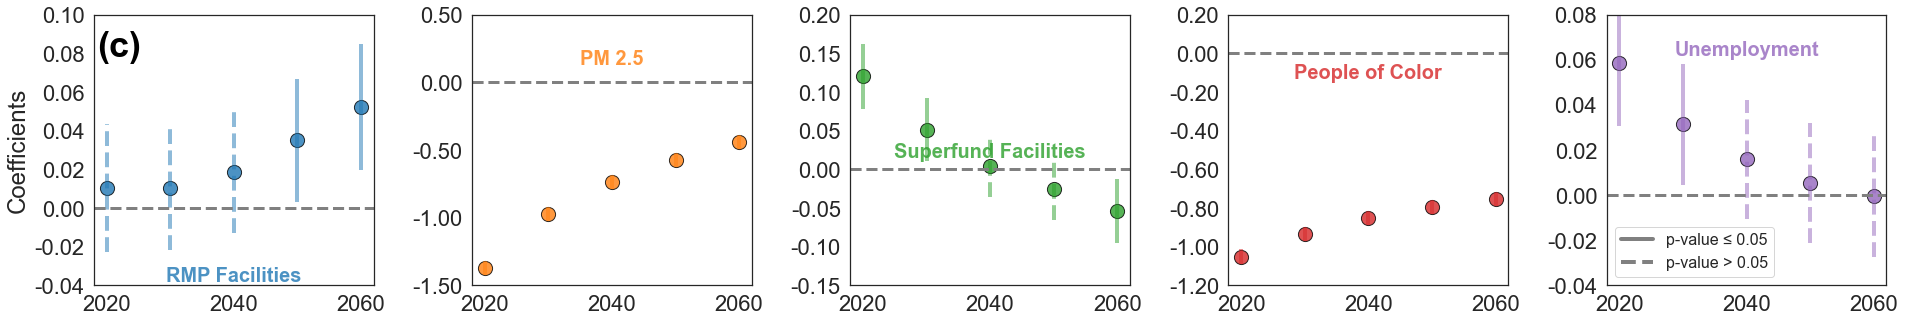

In [360]:
import matplotlib.lines as mlines

labels_dict = {'P_PRMP': 'RMP Facilities', 
                'P_PM25': 'PM 2.5', 
                'P_LDPNT': 'Lead Paint', 
                'P_PEOPCOLORPCT': 'People of Color', 
                'P_LOWINCPCT':'Low Income',
                'income_log_pct': 'Income',
                'P_UNEMPPCT': 'Unemployment',
                'P_PNPL': 'Superfund Facilities', 
                'P_PTSDF': 'Hazardous Waste', 
                'P_LESSHSPCT':'ed'}

colors = sns.color_palette("tab10", 5)

pval_threshold = 0.059

sns.set(style='white', font_scale=2)
fig, ax = plt.subplots(1, 5, figsize=(27, 5))
plt.subplots_adjust(wspace=0.25) 

for i, feature in enumerate(['P_PRMP', 'P_PM25', 'P_PNPL', 'P_PEOPCOLORPCT', 'P_UNEMPPCT']):
    for j, year in enumerate(coeffs_df['year']):
        pval = coeffs_df['{}_pval'.format(feature)].iloc[j]
        if pval < pval_threshold:
            linestyle = '-'
        else:
            linestyle = '--'  # Dashed line for non-significant p-values
        ax[i].vlines(year, coeffs_df['{}_lower'.format(feature)].iloc[j], coeffs_df['{}_upper'.format(feature)].iloc[j], 
                     alpha=0.5, lw=4, color=colors[i], linestyle=linestyle)
    ax[i].scatter(coeffs_df['year'], coeffs_df[feature], marker='o', label=feature, edgecolors='black', 
                  s=200, alpha=0.8, color=colors[i])
    ax[i].axhline(0, color='grey', lw=3, linestyle='--')
    if feature == 'P_PEOPCOLORPCT':
        ax[i].text(2040,-0.15, labels_dict[feature], ha='center', va='bottom', fontsize=20, fontweight='bold', alpha=0.8, color=colors[i])
    elif feature == 'P_PRMP':
        ax[i].text(2040,-0.04, labels_dict[feature], ha='center', va='bottom', fontsize=20, fontweight='bold', alpha=0.8, color=colors[i])
    elif feature == 'P_PM25':
        ax[i].text(2040,0.1, labels_dict[feature], ha='center', va='bottom', fontsize=20, fontweight='bold', alpha=0.8, color=colors[i])
    elif feature == 'P_UNEMPPCT':
        ax[i].text(2040,0.06, labels_dict[feature], ha='center', va='bottom', fontsize=20, fontweight='bold', alpha=0.8, color=colors[i])
        ax[i].set_ylim(-0.04, 0.08)  # Set y-axis limit for P_UNEMPPCT
    else:
        ax[i].text(2040,0.01, labels_dict[feature], ha='center', va='bottom', fontsize=20, fontweight='bold', alpha=0.8, color=colors[i])
    ax[i].set_ylabel('')
    
    yticks = ax[i].get_yticks()
    ax[i].set_yticks(yticks)  # Set the existing y-tick locations
    ax[i].set_yticklabels([f'{ytick:.2f}' for ytick in yticks])  # Format y-tick labels

    if i == 0:
        ax[i].text(2022, 0.075, '(c)', ha='center', va='bottom', fontsize=36, fontweight='bold', color='black')
        ax[i].set_ylabel('Coefficients')

solid_line = mlines.Line2D([], [], color='grey', linestyle='-', label='p-value ≤ 0.05', lw=4)
dashed_line = mlines.Line2D([], [], color='grey', linestyle='--', label='p-value > 0.05', lw=4)
ax[-1].legend(handles=[solid_line, dashed_line], loc='lower left', fontsize=16)

# solid_line = mlines.Line2D([], [], color='black', linestyle='-', label='Significant (p < 0.05)', lw=4)
# dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Not Significant (p ≥ 0.05)', lw=4)
# o_marker = mlines.Line2D([], [], color='black', marker='o', linestyle='', label='Midpoint Marker', markersize=10)
# ax[-1].legend(handles=[solid_line, dashed_line, o_marker], loc='lower left', fontsize=15)

plt.tight_layout()

In [29]:
emission_df = ols_df_process_emission(2020)[['CNTY_NAME', 'pc_emission']].drop_duplicates(subset=['CNTY_NAME'])
emission_df.rename(columns={'pc_emission': 'pc_emission_{}'.format(2020)}, inplace=True)
for year in [2030, 2040, 2050, 2060]:
    print(year)
    df_ = ols_df_process_emission(year)[['CNTY_NAME', 'pc_emission']].drop_duplicates(subset=['CNTY_NAME'])
    df_.rename(columns={'pc_emission': 'pc_emission_{}'.format(year)}, inplace=True)
    emission_df = emission_df.merge(df_, on='CNTY_NAME', how='inner')

2030
2040
2050
2060


In [326]:
# emission_df = ols_df_process_emission(2020)[['ID', 'pc_emission']]
# emission_df.rename(columns={'pc_emission': 'pc_emission_{}'.format(2020)}, inplace=True)
# for year in [2030, 2040, 2050, 2060]:
#     df = ols_df_process_emission(year)
#     df_ = df[['ID', 'pc_emission']]
#     df_.rename(columns={'pc_emission': 'pc_emission_{}'.format(year)}, inplace=True)
#     emission_df = emission_df.merge(df_, on='ID', how='inner')

sample_ = pd.read_csv("Allocation to Census tracts_v3/11_CTInUseEmission_High_StatusQuo/CTInUseEmission_High_StatusQuo_2020.csv")[['GEO_ID', '2020']]
for year in [2030, 2040, 2050, 2060]:
    sample__ = pd.read_csv("Allocation to Census tracts_v3/11_CTInUseEmission_High_StatusQuo/CTInUseEmission_High_StatusQuo_{}.csv".format(year))[['GEO_ID', '{}'.format(year)]]
    sample_ = sample_.merge(sample__, on='GEO_ID', how='inner')

In [323]:
sample_ = pd.read_csv('County level analysis/Data source/InUseEmission_High_StatusQuo.csv')

### Figure 4.a

In [1]:
def plot_lorenz_curves(data, columns, styles):
    sns.set(style='white', font_scale=1.5)
    plt.figure(figsize=(9, 7))
    for column, style in zip(columns, styles):
        gini, cum_pop, cum_exp = gini_index(data[column])
        plt.plot(cum_pop, cum_exp, style, label=f'{column[-4:]} (Gini = {gini:.3f})', lw=2.5)
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Line of Equality', lw=2)
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    
    plt.xlabel('Cumulative Proportion of Census Tracts')
    plt.ylabel('Cumulative Proportion of PFAS Emissions')
    # plt.title('Lorenz Curves')
    plt.legend()
    plt.text(0.9,0.1, '(a)', ha='center', va='bottom', fontsize=32, fontweight='bold', color='black')
    plt.tight_layout()

# columns = ['pc_emission_2020', 'pc_emission_2030', 'pc_emission_2040', 'pc_emission_2050', 'pc_emission_2060']
# styles = ['b-', 'g--', 'r-.', 'c:', 'm--']
# plot_lorenz_curves(emission_df, columns, styles)

columns = ['2020', '2030', '2040', '2050', '2060']
styles = ['b-', 'g--', 'r-.', 'c:', 'm--']
plot_lorenz_curves(sample_, columns, styles)

### heatmap for SI

In [279]:
ejscreen = pd.read_csv('Allocation to Census tracts_v3/population_results/heatmaps/ejscreen_2020_impacted_cts_km.csv')
ejscreen_og = pd.read_csv('EJSCREEN/EJSCREEN_2023_Tracts_with_AS_CNMI_GU_VI_csv/EJSCREEN_2023_Tracts_with_AS_CNMI_GU_VI.csv')

In [ ]:
def hmap(fcol, fcol_label, type='leachate'):
   quantiles = ejscreen['{}_pfas_within_10'.format(type)].quantile(np.arange(0, 1.1, 0.1))
   ejscreen['quantile_range'] = pd.cut(ejscreen['{}_pfas_within_10'.format(type)], bins=quantiles, labels=False, include_lowest=True)
   heatmap_data = np.zeros((10, 10))  # 10x10 matrix for the heatmap
   for i in range(10):
       for j in range(10):
           # Filter rows in the j-th quantile
           quantile_rows = ejscreen[ejscreen['quantile_range'] == j]
           quantile_rows= quantile_rows[quantile_rows[f'{type}_pfas_within_{i+1}'] > 0]
           # Calculate median income for the i-th pfas_within column within the j-th quantile
           median_income = quantile_rows[fcol].median()
           heatmap_data[j, i] = median_income
   center_val = ejscreen_og[fcol].median()


   ytlabels = ['[{:.1f}, {:.1f}]'.format(quantiles.tolist()[i], quantiles.tolist()[i+1]) for i in range(10)]
   ytlabels = ytlabels[::-1]
   sns.set(style='white', font_scale=1.5)
   plt.figure(figsize=(12, 9))
   heatmap_plot = sns.heatmap(heatmap_data[::-1], annot=True, fmt=".1f", cmap='RdYlGn_r',
               # add the cells boundaries color to be white
               linecolor='white', linewidth=0.5,
               xticklabels=[f'{i}' for i in range(1, 11)],
               # use quantiles list to label the y-axis
               yticklabels=ytlabels,
               # vmin=0,
               # vmax=100
               center=center_val
               )
   # plt.title('Median Income by PFAS Distance and Quantile')
   colorbar = heatmap_plot.collections[0].colorbar
   colorbar.set_label('Median Percentile {}'.format(fcol_label))
   plt.xlabel('Exposure Threshold (km)')
   plt.ylabel('Cumulated PFAS Range (kg)')
   # save the figure
   plt.tight_layout()

In [ ]:
feature_cols = [
'P_PEOPCOLORPCT',
'P_LOWINCPCT',
'P_UNEMPPCT',
'P_RSEI_AIR',
'P_D2_PM25',
#  'P_D2_OZONE',
'P_D2_DSLPM',
#  'P_D2_CANCER',
'P_D2_RESP',
#  'P_D2_RSEI_AIR',
'P_D2_PTRAF',
'P_D2_LDPNT',
'P_D2_PNPL',
'P_D2_PRMP',
#  'P_D2_PTSDF',
#  'P_D2_UST',
'P_D2_PWDIS',
]
metric_vars = [
'People of Color',
'Low Income',
'Unemployment',
'Toxic Releases to Air',
'PM2.5',
#  'P_D2_OZONE',
'Diesel PM',
#  'P_D2_CANCER',
'Air Toxics Respiratory',
#  'P_D2_RSEI_AIR',
'Traffic Proximity',
'Lead Paint',
'Superfund Proximity',
'RMP Proximity',
#  'P_D2_PTSDF',
#  'P_D2_UST',
'Wastewater Discharges',
]

In [ ]:
def hmap_subplot(ax, fcol, fcol_label, type='leachate'):
   quantiles = ejscreen['{}_pfas_within_10'.format(type)].quantile(np.arange(0, 1.1, 0.1))
   ejscreen['quantile_range'] = pd.cut(ejscreen['{}_pfas_within_10'.format(type)], bins=quantiles, labels=False, include_lowest=True)
   heatmap_data = np.zeros((10, 10))  # 10x10 matrix for the heatmap
   for i in range(10):
       for j in range(10):
           quantile_rows = ejscreen[ejscreen['quantile_range'] == j]
           quantile_rows = quantile_rows[quantile_rows[f'{type}_pfas_within_{i+1}'] > 0]
           median_income = quantile_rows[fcol].median()
           heatmap_data[j, i] = median_income
   center_val = ejscreen_og[fcol].median()


   ytlabels = ['[{:.1f}, {:.1f}]'.format(quantiles.tolist()[i], quantiles.tolist()[i+1]) for i in range(10)]
   ytlabels = ytlabels[::-1]


   heatmap_plot = sns.heatmap(heatmap_data[::-1], annot=True, fmt=".1f", cmap='RdYlGn_r',
               linecolor='white', linewidth=0.5,
               xticklabels=[f'{i}' for i in range(1, 11)],
               yticklabels=ytlabels,
               center=center_val, ax=ax)


   if fcol == 'P_D2_PRMP' or fcol == 'P_D2_PWDIS':
       ax.set_xlabel('Exposure Threshold (km)')
   else:
       ax.set_xlabel('')
   # if fcol
   # if fcol == 'P_PEOPCOLORPCT' or fcol == 'P_UNEMPPCT' or fcol == 'P_D2_PM25':
   if fcol == 'P_D2_RESP' or fcol == 'P_D2_LDPNT' or fcol == 'P_D2_PRMP':
       ax.set_ylabel('Cumulated PFAS Range (kg)') 
       ax.set_yticklabels(ytlabels, fontsize=12)
   else:
       ax.set_ylabel('')
       ax.set_yticks([])


   # Add colorbar label
   colorbar = heatmap_plot.collections[0].colorbar
   colorbar.set_label('Median Percentile {}'.format(fcol_label), fontsize=14)


# Create a figure with 2 columns and 3 rows
fig, axs = plt.subplots(3, 2, figsize=(20, 23))  # Adjust figsize for appropriate scaling


# Plot the first six features in the feature_cols and metric_vars
for i, (fcol, fcol_label) in enumerate(zip(feature_cols[6:], metric_vars[6:])):
   row = i // 2
   col = i % 2
   hmap_subplot(axs[row, col], fcol, fcol_label, type='accu')


plt.tight_layout()